In [1]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from Model import SuperPointFrontend,SuperPointNet
import os

In [2]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from Model import SuperPointFrontend,SuperPointNet
import os

def keypoint(img_path):
    # Ruta al modelo de pesos preentrenados de SuperPoint
    weights_path = 'superpoint_v1.pth'
    nms_dist = 4  # Distancia de NMS
    conf_thresh = 0.015  # Umbral de confianza para detectar puntos
    nn_thresh = 0.7  # Umbral de coincidencia de descriptor
    cuda = torch.cuda.is_available()  # Detecta si hay GPU disponible
    # Cargar la clase SuperPointFrontend
    sp = SuperPointFrontend(weights_path, nms_dist, conf_thresh, nn_thresh, cuda)
    # Cargar la imagen de entrada
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Cargar la imagen en escala de grises
    img = img.astype(np.float32) / 255.0  # Normalizar a [0,1]
    # Ejecutar la red SuperPoint en la imagen
    pts, desc, heatmap = sp.run(img)
    return [pts,desc,heatmap,img]

def match(desc1,desc2):
    # Realizar la coincidencia de descriptores usando un KNN Matcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # Usamos L2 para la coincidencia de descriptores
    matches = bf.knnMatch(desc1.T, desc2.T, k=2)  # Coincidencias con los dos mejores vecinos   
    # Aplicar el ratio de Lowe para filtrar coincidencias malas
    good_matches = []
    for m, n in matches:
        if m.distance < 0.9 * n.distance:  # Umbral de Lowe
            good_matches.append(m)
    return good_matches


def cargar_calibracion(calib_path):
    # Leer el archivo de calibración
    calib = {}
    with open(calib_path, 'r') as file:
        for line in file:
            parts = line.strip().split(':')
            if len(parts) > 1:
                key, values = parts[0], parts[1].split()
                calib[key] = np.array([float(val) for val in values])

    # Obtener la matriz intrínseca P0 (cámara 0)
    P0 = calib['P0'].reshape(3, 4)  # P0 es una matriz 3x4
    K = P0[:, :3]  # Matriz intrínseca K es la submatriz 3x3

    return K


def calcular_relativa_R_t(img_path_ref, img_path_cur, K):
    # Paso 1: Obtener puntos clave y descriptores para las imágenes de referencia y actual
    pts_ref, desc_ref, heatmap_ref, img_ref = keypoint(img_path_ref)
    pts_cur, desc_cur, heatmap_cur, img_cur = keypoint(img_path_cur)
    # Convertir los puntos a KeyPoints
    keypoints1 = [cv2.KeyPoint(x=float(x), y=float(y), size=1.0) for x, y in zip(pts_ref[0, :], pts_ref[1, :])]
    keypoints2 = [cv2.KeyPoint(x=float(x), y=float(y), size=1.0) for x, y in zip(pts_cur[0, :], pts_cur[1, :])]
    # Paso 2: Coincidir los descriptores entre las dos imágenes
    good_matches = match(desc_ref, desc_cur)
    pts_ref_matched = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    pts_cur_matched = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
    # Paso 3: Calcular la matriz esencial usando las coordenadas de los puntos clave y la matriz intrínseca K
    E, mask = cv2.findEssentialMat(pts_cur_matched, pts_ref_matched, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    # Paso 4: Recuperar la rotación R y la traslación t usando la matriz esencial E
    _, R, t, mask = cv2.recoverPose(E, pts_cur_matched, pts_ref_matched, K)
    return R, t


def crear_mapa_transformaciones(secuencia_imagenes, calib_path):
    K = cargar_calibracion(calib_path)
    R_global = np.eye(3)  # Matriz de rotación global
    t_global = np.zeros((3, 1))  # Vectores de traslación global
    posiciones = []
    for i in range(1, len(secuencia_imagenes)):
        img_path_ref = secuencia_imagenes[i - 1]
        img_path_cur = secuencia_imagenes[i]
        # Calcular la rotación y la traslación relativa
        R_rel, t_rel = calcular_relativa_R_t(img_path_ref, img_path_cur, K)
        # Acumular las transformaciones
        t_global += R_global @ t_rel
        R_global = R_global @ R_rel
        # Almacenar la posición actual (traslación acumulada)
        posiciones.append(t_global.flatten())
    return np.array(posiciones)

def obtener_secuencia_imagenes(directorio_imagenes):
    # Listar todos los archivos en la carpeta
    archivos = os.listdir(directorio_imagenes)
    
    # Filtrar solo los archivos PNG y ordenarlos numéricamente
    archivos_imagenes = sorted([f for f in archivos if f.endswith('.png')], key=lambda x: int(x.split('.')[0]))
    
    # Generar las rutas completas de las imágenes
    rutas_imagenes = [os.path.join(directorio_imagenes, f) for f in archivos_imagenes]
    
    return rutas_imagenes


def cargar_groundtruth(path_groundtruth):
    posiciones = []
    with open(path_groundtruth, 'r') as f:
        for line in f:
            data = line.split()
            x, y, z = map(float, data[1:4])  # Posición (x, y, z)
            posiciones.append(np.array([x, y, z]))
    return np.array(posiciones)

def ajustar_escala(poses_relativas, groundtruth_poses):
    # Calcular las distancias entre las posiciones relativas
    distancias_relativas = np.linalg.norm(np.diff(poses_relativas, axis=0), axis=1)
    # Calcular las distancias reales entre las posiciones de groundtruth
    distancias_groundtruth = np.linalg.norm(np.diff(groundtruth_poses[1:], axis=0), axis=1)
    # Calcular un factor de escala
    escala = np.mean(distancias_groundtruth / distancias_relativas)
    print(escala)
    # Ajustar las transformaciones relativas aplicando la escala
    poses_ajustadas = poses_relativas * escala
    return poses_ajustadas

def plot_gt(path,pos_pred):
    # Load the ground truth poses (1x12 vectors from the 'poses.txt' file)
    ground_truth_poses = np.loadtxt(path)  # shape: (N, 12)

    print(ground_truth_poses.shape)

    # Extract x and y coordinates (ignoring the orientation)
    ground_truth_poses = ground_truth_poses.reshape(len(ground_truth_poses), 3, 4) #reshape into Homogeneous matrix

    x_positions = ground_truth_poses[:,:,-1][:, 0]
    y_positions = ground_truth_poses[:,:,-1][:, 2] # z is the y coordinate in the 2D plane seen from above (z points forward in the camera frame)


    # replace this with your model predictions
    # for _ in ...
    # pose[t] = model(img[t], imt[t-1]) ... blablabla

    pred_poses_x =pos_pred[:, 0]
    pred_poses_y = pos_pred[:, 2]

    # calculate metrics
    # rmse = ...

    # Plot the ground truth trajectory in 2D (X-Y plane)
    plt.figure(figsize=(8, 6))
    plt.plot(pred_poses_x, pred_poses_y, label='Model predictions', color='r', linewidth=2)
    plt.plot(x_positions, y_positions, label='Ground Truth Path', color='b', linewidth=2)
    plt.title('Ground Truth Trajectory (2D)', fontsize=16)
    plt.xlabel('X Position (meters)', fontsize=12)
    plt.ylabel('Y Position (meters)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


c:\Users\fersa\OneDrive\Escritorio\Proyecto_imagenes\Model.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(weights_path))


Número de puntos detectados: 758


C:\Users\fersa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


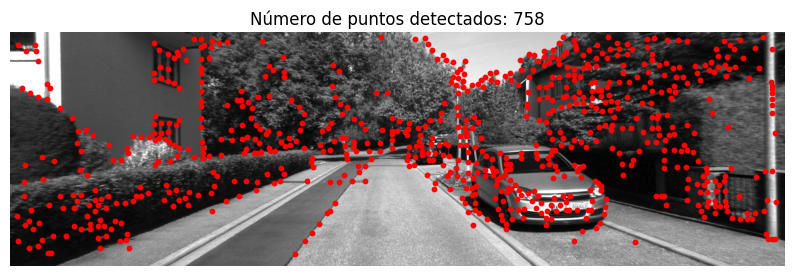

In [3]:

pts, desc, heatmap,img = keypoint('data_odometry_gray/dataset/sequences/03/image_0/000000.png')

# Mostrar resultados
if pts.shape[1] > 0:
    print(f'Número de puntos detectados: {pts.shape[1]}')

    # Mostrar los puntos en la imagen utilizando matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')  # Mostrar la imagen en escala de grises

    # Convertir pts (que son [y, x, confianza]) a coordenadas (x, y)
    x_coords = pts[0, :]
    y_coords = pts[1, :]

    # Dibujar los puntos sobre la imagen
    plt.scatter(x_coords, y_coords, c='r', s=10)  # Dibujar los puntos en rojo

    # Títulos y etiquetas
    plt.title(f'Número de puntos detectados: {pts.shape[1]}')
    plt.axis('off')  # No mostrar ejes

    # Mostrar la imagen con puntos
    plt.show()
else:
    print("No se detectaron puntos.")

(256, 1118)
(256, 1112)


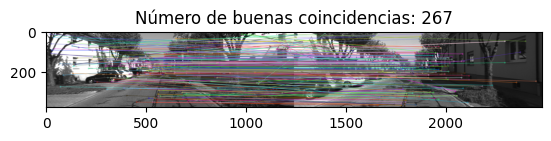

In [4]:
# Cargar las dos imágenes consecutivas (por ejemplo, imagen1 e imagen2)
img1_path = 'data_odometry_gray/dataset/sequences/00/image_0/000010.png'
img2_path = 'data_odometry_gray/dataset/sequences/00/image_0/000020.png'

# Ejecutar SuperPoint en ambas imágenes
pts1, desc1, _, img1 = keypoint(img1_path)
pts2, desc2, _, img2 = keypoint(img2_path)
print(desc1.shape)
print(desc2.shape)
# Convertir los puntos a KeyPoints
keypoints1 = [cv2.KeyPoint(x=float(x), y=float(y), size=1.0) for x, y in zip(pts1[0, :], pts1[1, :])]
keypoints2 = [cv2.KeyPoint(x=float(x), y=float(y), size=1.0) for x, y in zip(pts2[0, :], pts2[1, :])]

# Realizar la coincidencia de descriptores
good_matches = match(desc1, desc2)

# Convertir las imágenes de float32 a uint8
img1_uint8 = np.uint8(img1 * 255)  # Convertir a [0, 255] y cambiar a uint8
img2_uint8 = np.uint8(img2 * 255)  # Convertir a [0, 255] y cambiar a uint8

# Visualizar las coincidencias
img_matches = cv2.drawMatches(img1_uint8, keypoints1, img2_uint8, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Mostrar las coincidencias
plt.imshow(img_matches)
plt.title(f'Número de buenas coincidencias: {len(good_matches)}')
plt.show()

In [ ]:
# Cargar las posiciones del groundtruth
path_groundtruth = "data_odometry_poses/dataset/poses/03.txt"
groundtruth_poses = cargar_groundtruth(path_groundtruth)
# Definir la ruta de las imágenes en la secuencia 03
directorio_imagenes = "data_odometry_gray/dataset/sequences/03/image_0/"
# Obtener todas las rutas de las imágenes de la secuencia
secuencia_imagenes = obtener_secuencia_imagenes(directorio_imagenes)
# Cargar el archivo de calibración
calib_path = "data_odometry_calib/dataset/sequences/03/calib.txt"
# Crear el mapa de transformaciones
posiciones_globales = crear_mapa_transformaciones(secuencia_imagenes, calib_path)

0.5915091292774054


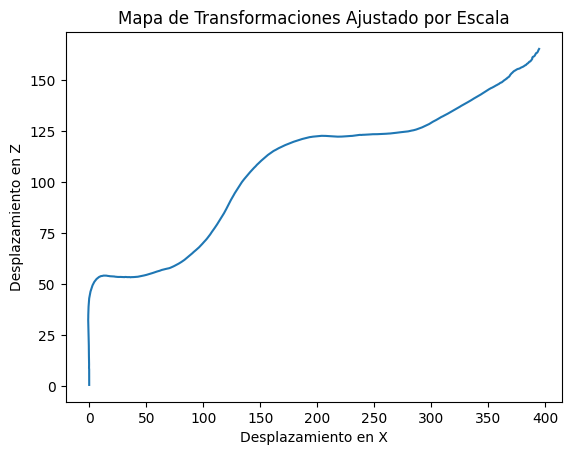

In [29]:
# Ajustar la escala usando las posiciones de groundtruth
posiciones_ajustadas = ajustar_escala(posiciones_globales, groundtruth_poses)

# Visualizar el mapa de transformaciones ajustado
plt.plot(posiciones_ajustadas[:,0], posiciones_ajustadas[:,2])
plt.xlabel("Desplazamiento en X")
plt.ylabel("Desplazamiento en Z")
plt.title("Mapa de Transformaciones Ajustado por Escala")
plt.show()

(801, 12)


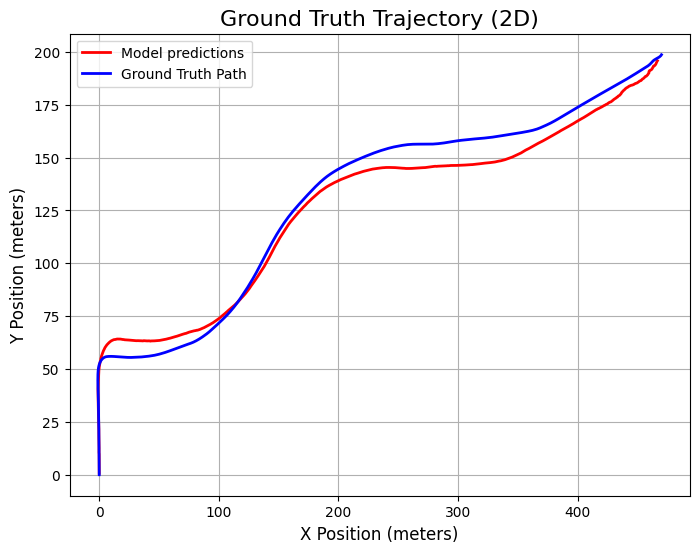

In [36]:
plot_gt("data_odometry_poses/dataset/poses/03.txt",posiciones_globales*0.7)

In [45]:
def calcular_error_posicion(poses_estimadas, groundtruth_poses):
    # Seleccionar solo las coordenadas x y z (ignorando la componente y)
    poses_estimadas_xz = poses_estimadas[:, [0, 2]]
    groundtruth_poses_xz = groundtruth_poses[:, [0, 2]]
    
    # Calcular la distancia Euclidiana entre las poses estimadas y las del ground truth
    error_posicion = np.mean(np.linalg.norm(poses_estimadas_xz - groundtruth_poses_xz, axis=1))
    return error_posicion


In [48]:
a=groundtruth_poses[1:]
b=posiciones_globales
calcular_error_posicion(a,b)

244.817331712816